# 1. Import libraries

In [2]:
import numpy as np
import pandas as pd
import sklearn

import os

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin  # for making a user defined class sklearn compatible
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    OrdinalEncoder
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance  # for feature selection
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt
import warnings

import joblib

# 2. Display setting

In [4]:
# setting the display output as pandas dataframe

sklearn.set_config(transform_output="pandas")

In [5]:
# get all columns while displaying a dataframe
pd.set_option("display.max_columns", None)

In [6]:
# ignoring warnings
warnings.filterwarnings("ignore")

# 3. Reading the data

In [3]:
path = r"C:\Users\DELL\Desktop\Programming\ml-project2-flight-price-prediction-using-aws-sagemaker\data\train.csv"

train = pd.read_csv(path)

In [6]:
train.additional_info.unique()

array(['No Info', 'In-Flight Meal Not Included',
       'No Check-In Baggage Included', '1 Long Layover',
       'Change Airports', 'Business Class', 'Red-Eye Flight'],
      dtype=object)

In [8]:
train.sample(5)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3726,Indigo,2019-05-21,Delhi,Cochin,23:30:00,04:35:00,305,1.0,No Info,8745
3725,Indigo,2019-06-18,Delhi,Cochin,05:35:00,08:50:00,195,0.0,No Info,5000
4716,Jet Airways,2019-03-21,Delhi,Cochin,13:00:00,04:25:00,925,1.0,In-Flight Meal Not Included,7438
197,Jet Airways,2019-06-15,Banglore,Delhi,15:15:00,18:10:00,175,0.0,In-Flight Meal Not Included,7229
718,Air India,2019-06-06,Mumbai,Hyderabad,13:55:00,15:25:00,90,0.0,No Info,3625


In [9]:
# getting some basic info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6276 non-null   object 
 1   date_of_journey  6276 non-null   object 
 2   source           6276 non-null   object 
 3   destination      6276 non-null   object 
 4   dep_time         6276 non-null   object 
 5   arrival_time     6276 non-null   object 
 6   duration         6276 non-null   int64  
 7   total_stops      6275 non-null   float64
 8   additional_info  6276 non-null   object 
 9   price            6276 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 490.4+ KB


In [10]:
# splitting the data into x and y

X_train = train.drop(columns="price")
y_train = train.price.copy()

In [11]:
X_train.shape, y_train.shape

((6276, 9), (6276,))

# 4. Transformation operations

## 4.1 airline

In [12]:
X_train.airline.value_counts()

airline
Jet Airways          2240
Indigo               1221
Air India            1010
Multiple Carriers     688
Spicejet              501
Vistara               298
Air Asia              200
Goair                 117
Trujet                  1
Name: count, dtype: int64

In [13]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
6271,0.0,0.0,1.0,0.0,0.0
6272,1.0,0.0,0.0,0.0,0.0
6273,0.0,0.0,1.0,0.0,0.0
6274,0.0,0.0,0.0,0.0,1.0


## 4.2 date_of_journey

In [14]:
X_train.date_of_journey

0       2019-05-15
1       2019-06-27
2       2019-06-03
3       2019-04-01
4       2019-05-18
           ...    
6271    2019-03-21
6272    2019-05-01
6273    2019-06-01
6274    2019-06-24
6275    2019-03-01
Name: date_of_journey, Length: 6276, dtype: object

In [15]:
# extracting feature from datetime feature 

feature_to_extract = ["month","week","day_of_week","day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),  # DatetimeFeature auto convert object to datetime
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.647059,0.333333,0.635593
1,1.000000,1.000000,0.500000,1.000000
2,1.000000,0.823529,0.000000,0.796610
3,0.333333,0.294118,0.000000,0.262712
4,0.666667,0.647059,0.833333,0.661017
...,...,...,...,...
6271,0.000000,0.176471,0.500000,0.169492
6272,0.666667,0.529412,0.333333,0.516949
6273,1.000000,0.764706,0.833333,0.779661
6274,1.000000,1.000000,0.000000,0.974576


## 4.3 source & destination

In [16]:
X_train.source.value_counts(), X_train.destination.value_counts()

(source
 Delhi       2565
 Kolkata     1732
 Banglore    1338
 Mumbai       422
 Chennai      219
 Name: count, dtype: int64,
 destination
 Cochin       2565
 Banglore     1732
 Delhi         791
 New Delhi     547
 Hyderabad     422
 Kolkata       219
 Name: count, dtype: int64)

In [17]:
# creating a df containing source and destination only
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Mumbai,Hyderabad
1,Delhi,Cochin
2,Delhi,Cochin
3,Kolkata,Banglore
4,Kolkata,Banglore
...,...,...
6271,Delhi,Cochin
6272,Kolkata,Banglore
6273,Delhi,Cochin
6274,Delhi,Cochin


In [18]:
# pipe 1 for location
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())  # it transform and scale
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-1.889834,-0.738999
1,1.065138,1.061367
2,1.065138,1.061367
3,-0.210080,-0.229582
4,-0.210080,-0.229582
...,...,...
6271,1.065138,1.061367
6272,-0.210080,-0.229582
6273,1.065138,1.061367
6274,1.065138,1.061367


In [19]:
# getting unique cities name from source and destination

np.union1d(
    location_subset.source.unique(),
    location_subset.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [20]:
# function to check if a destination city is north or not

from sklearn.pipeline import FunctionTransformer


def is_north(X):
    columns = X.columns.to_list()
    
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

# is_north(location_subset) 

# to make it sklearn compatible
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
6271,1,0
6272,1,0
6273,1,0
6274,1,0


In [21]:
# final location transformer

location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-1.889834,-0.738999,1,0
1,1.065138,1.061367,1,0
2,1.065138,1.061367,1,0
3,-0.210080,-0.229582,1,0
4,-0.210080,-0.229582,1,0
...,...,...,...,...
6271,1.065138,1.061367,1,0
6272,-0.210080,-0.229582,1,0
6273,1.065138,1.061367,1,0
6274,1.065138,1.061367,1,0


## 4.4 dep_time & arrival_time

In [22]:
X_train.dep_time

0       19:30:00
1       13:25:00
2       21:25:00
3       06:30:00
4       16:50:00
          ...   
6271    10:45:00
6272    09:25:00
6273    14:00:00
6274    07:55:00
6275    11:50:00
Name: dep_time, Length: 6276, dtype: object

In [23]:
X_train.arrival_time

0       20:45:00
1       19:00:00
2       19:00:00
3       04:40:00
4       13:45:00
          ...   
6271    18:50:00
6272    18:30:00
6273    19:00:00
6274    13:25:00
6275    08:55:00
Name: arrival_time, Length: 6276, dtype: object

In [24]:
time_subset = X_train.loc[:,["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,19:30:00,20:45:00
1,13:25:00,19:00:00
2,21:25:00,19:00:00
3,06:30:00,04:40:00
4,16:50:00,13:45:00
...,...,...
6271,10:45:00,18:50:00
6272,09:25:00,18:30:00
6273,14:00:00,19:00:00
6274,07:55:00,13:25:00


In [25]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.826087,0.545455,0.869565,0.818182
1,0.565217,0.454545,0.826087,0.000000
2,0.913043,0.454545,0.826087,0.000000
3,0.260870,0.545455,0.173913,0.727273
4,0.695652,0.909091,0.565217,0.818182
...,...,...,...,...
6271,0.434783,0.818182,0.782609,0.909091
6272,0.391304,0.454545,0.782609,0.545455
6273,0.608696,0.000000,0.826087,0.000000
6274,0.304348,1.000000,0.565217,0.454545


In [26]:
# now creating a new feature part of the day based on time

def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })
    
    return (
        X_temp
        .assign(**{
            f"{col}_part_of_the_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                 X_temp.loc[:, col].between(eve, night, inclusive="left"),],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )
    
# part_of_day(time_subset)
# making this function compatible to sklearn

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_the_day,arrival_time_part_of_the_day
0,evening,night
1,afternoon,evening
2,night,evening
3,morning,morning
4,evening,afternoon
...,...,...
6271,morning,evening
6272,morning,evening
6273,afternoon,evening
6274,morning,afternoon


In [27]:
# creating pipe 2 for time transformation

time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_the_day,arrival_time_part_of_the_day
0,0.203609,1.000000
1,0.000000,0.660256
2,0.173531,0.660256
3,1.000000,0.963675
4,0.203609,0.000000
...,...,...
6271,1.000000,0.660256
6272,1.000000,0.660256
6273,0.000000,0.660256
6274,1.000000,0.000000


In [28]:
# combining pipe1 and pipe2 

time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_the_day,arrival_time_part_of_the_day
0,0.826087,0.545455,0.869565,0.818182,0.203609,1.000000
1,0.565217,0.454545,0.826087,0.000000,0.000000,0.660256
2,0.913043,0.454545,0.826087,0.000000,0.173531,0.660256
3,0.260870,0.545455,0.173913,0.727273,1.000000,0.963675
4,0.695652,0.909091,0.565217,0.818182,0.203609,0.000000
...,...,...,...,...,...,...
6271,0.434783,0.818182,0.782609,0.909091,1.000000,0.660256
6272,0.391304,0.454545,0.782609,0.545455,1.000000,0.660256
6273,0.608696,0.000000,0.826087,0.000000,0.000000,0.660256
6274,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


## 4.5 duration

In [29]:
X_train.duration

0         75
1       1775
2       1295
3       1330
4       1255
        ... 
6271    1925
6272     545
6273     300
6274     330
6275    1265
Name: duration, Length: 6276, dtype: int64

In [30]:
# creating categories for duration

def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select(
            [X.duration.lt(short),
             X.duration.between(short, med, inclusive="left")],
            ["short", "medium"],
            default="long"
        ))
        .drop(columns="duration")
    )
    
duration_category(X_train)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info,duration_cat
0,Air India,2019-05-15,Mumbai,Hyderabad,19:30:00,20:45:00,0.0,No Info,short
1,Jet Airways,2019-06-27,Delhi,Cochin,13:25:00,19:00:00,2.0,No Info,long
2,Jet Airways,2019-06-03,Delhi,Cochin,21:25:00,19:00:00,2.0,No Info,long
3,Jet Airways,2019-04-01,Kolkata,Banglore,06:30:00,04:40:00,1.0,In-Flight Meal Not Included,long
4,Air India,2019-05-18,Kolkata,Banglore,16:50:00,13:45:00,2.0,No Info,long
...,...,...,...,...,...,...,...,...,...
6271,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,2.0,No Info,long
6272,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,1.0,No Info,long
6273,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,1.0,In-Flight Meal Not Included,medium
6274,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,1.0,No Info,medium


In [31]:
# checking id the duration is longer than given value

def is_over(X, value=1000):
    return (
        X.assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )
    
is_over(X_train)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info,duration_over_1000
0,Air India,2019-05-15,Mumbai,Hyderabad,19:30:00,20:45:00,0.0,No Info,0
1,Jet Airways,2019-06-27,Delhi,Cochin,13:25:00,19:00:00,2.0,No Info,1
2,Jet Airways,2019-06-03,Delhi,Cochin,21:25:00,19:00:00,2.0,No Info,1
3,Jet Airways,2019-04-01,Kolkata,Banglore,06:30:00,04:40:00,1.0,In-Flight Meal Not Included,1
4,Air India,2019-05-18,Kolkata,Banglore,16:50:00,13:45:00,2.0,No Info,1
...,...,...,...,...,...,...,...,...,...
6271,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,2.0,No Info,1
6272,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,1.0,No Info,0
6273,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,1.0,In-Flight Meal Not Included,0
6274,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,1.0,No Info,0


### creating a new feature from duration using rbfpercentitle similarity
RBF-percentile similarity operationalizes non-linear proximity into clean signals that boost model lift, mitigate distributional noise, and streamline deployment without inflating architectural complexity.

it is a feature engineering technique

In [32]:
# creating a class fro rbf percentile similarity

class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):  # we inherit from these two to make it sklearn compatible
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):  #gamma is to control underfitting and overfittung
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma
        
    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()
            
        self.reference_values_ = {
            col:(
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        
        return self  # to make it sklearn compatible
    
    # Returning self allows transform() to reuse them downstream without recomputing.
    
    def transform(self,X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:,[col]], Y=self.reference_values_[col], gamma=self.gamma),  # calculating rbf kernal based on reference value
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)
        

In [33]:
RBFPercentileSimilarity(percentiles=[0.4,0.8]).fit_transform(X_train.drop(columns='total_stops'))

# rbf_kernel always work if there is no missing value in the columns

,duration_rbf_40,duration_rbf_80
0,0.000000e+00,0.0
1,0.000000e+00,0.0
2,0.000000e+00,0.0
3,0.000000e+00,0.0
4,0.000000e+00,0.0
...,...,...
6271,0.000000e+00,0.0
6272,0.000000e+00,0.0
6273,4.225900e-132,0.0
6274,7.187782e-28,0.0


In [34]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short","medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.364119,-0.116634,-0.100794,0.0,0,-1.115266
1,-0.364119,-0.116634,-0.100794,2.0,1,2.290314
2,-0.364119,-0.116634,-0.100794,2.0,1,1.328738
3,-0.364119,-0.116634,-0.100794,2.0,1,1.398853
4,-0.364119,-0.116634,-0.100794,2.0,1,1.248607
...,...,...,...,...,...,...
6271,-0.364119,-0.116634,-0.100794,2.0,1,2.590806
6272,-0.364119,-0.116634,-0.100794,2.0,0,-0.173723
6273,-0.364119,-0.116634,-0.100794,1.0,0,-0.664527
6274,-0.364119,-0.116634,-0.100794,1.0,0,-0.604429


## 4.6 total_steps

In [35]:
X_train.total_stops.unique()

array([ 0.,  2.,  1.,  3., nan])

In [36]:
# creating a new feature if its direct or not
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

In [37]:
total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("direct", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,2.0,0
2,2.0,0
3,1.0,0
4,2.0,0
...,...,...
6271,2.0,0
6272,1.0,0
6273,1.0,0
6274,1.0,0


## 4.7 additional_info

In [38]:
X_train.additional_info.value_counts()

additional_info
No Info                         4928
In-Flight Meal Not Included     1132
No Check-In Baggage Included     194
1 Long Layover                    15
Change Airports                    4
Business Class                     2
Red-Eye Flight                     1
Name: count, dtype: int64

In [39]:
info_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-Flight Meal Not Included,additional_info_No Info,additional_info_other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6271,0.0,1.0,0.0
6272,0.0,1.0,0.0
6273,1.0,0.0,0.0
6274,0.0,1.0,0.0


In [40]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [41]:
# have_info(X_train)

In [42]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [43]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-Flight Meal Not Included,additional_info_No Info,additional_info_other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0
...,...,...,...,...
6271,0.0,1.0,0.0,0
6272,0.0,1.0,0.0,0
6273,1.0,0.0,0.0,1
6274,0.0,1.0,0.0,0


## 4.8 combining all transformations (using column transformer)

In [44]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", "destination"]),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_the_day,time__arrival_time_part_of_the_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-Flight Meal Not Included,info__additional_info_No Info,info__additional_info_other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-1.889834,-0.738999,1,0,0.826087,0.545455,0.869565,0.818182,0.203609,1.000000,-0.364119,-0.116634,-0.100794,0.0,0,-1.115266,0.0,1,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,1.065138,1.061367,1,0,0.565217,0.454545,0.826087,0.000000,0.000000,0.660256,-0.364119,-0.116634,-0.100794,2.0,1,2.290314,2.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,1.065138,1.061367,1,0,0.913043,0.454545,0.826087,0.000000,0.173531,0.660256,-0.364119,-0.116634,-0.100794,2.0,1,1.328738,2.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,-0.210080,-0.229582,1,0,0.260870,0.545455,0.173913,0.727273,1.000000,0.963675,-0.364119,-0.116634,-0.100794,2.0,1,1.398853,1.0,0,1.0,0.0,0.0,1
4,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.210080,-0.229582,1,0,0.695652,0.909091,0.565217,0.818182,0.203609,0.000000,-0.364119,-0.116634,-0.100794,2.0,1,1.248607,2.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6271,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.065138,1.061367,1,0,0.434783,0.818182,0.782609,0.909091,1.000000,0.660256,-0.364119,-0.116634,-0.100794,2.0,1,2.590806,2.0,0,0.0,1.0,0.0,0
6272,1.0,0.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.210080,-0.229582,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.660256,-0.364119,-0.116634,-0.100794,2.0,0,-0.173723,1.0,0,0.0,1.0,0.0,0
6273,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.065138,1.061367,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.660256,-0.364119,-0.116634,-0.100794,1.0,0,-0.664527,1.0,0,1.0,0.0,0.0,1
6274,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,1.065138,1.061367,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.364119,-0.116634,-0.100794,1.0,0,-0.604429,1.0,0,0.0,1.0,0.0,0


# 5. Feature selection

In [45]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1  # performance meets or exceeds 0.10 (10% R²) make it through to the final feature set.
)


# 6. putting it all together

In [46]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.647059,0.635593,-1.889834,-0.738999,-0.364119,0.0,0,-1.115266,0.0,1
1,0.0,1.0,0.0,1.000000,1.000000,1.065138,1.061367,-0.364119,2.0,1,2.290314,2.0,0
2,0.0,1.0,0.0,0.823529,0.796610,1.065138,1.061367,-0.364119,2.0,1,1.328738,2.0,0
3,0.0,1.0,0.0,0.294118,0.262712,-0.210080,-0.229582,-0.364119,2.0,1,1.398853,1.0,0
4,0.0,0.0,0.0,0.647059,0.661017,-0.210080,-0.229582,-0.364119,2.0,1,1.248607,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6271,0.0,1.0,0.0,0.176471,0.169492,1.065138,1.061367,-0.364119,2.0,1,2.590806,2.0,0
6272,0.0,0.0,0.0,0.529412,0.516949,-0.210080,-0.229582,-0.364119,2.0,0,-0.173723,1.0,0
6273,0.0,1.0,0.0,0.764706,0.779661,1.065138,1.061367,-0.364119,1.0,0,-0.664527,1.0,0
6274,0.0,0.0,1.0,1.000000,0.974576,1.065138,1.061367,-0.364119,1.0,0,-0.604429,1.0,0


# 7. Visualizations

In [47]:
# getting the performance of the feature

feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(0.0010159505121596728),
 'air__airline_Indigo': np.float64(0.1279898501213095),
 'air__airline_Jet Airways': np.float64(0.19467198354266504),
 'air__airline_Multiple Carriers': np.float64(0.018680450114663794),
 'air__airline_other': np.float64(0.11622293940922723),
 'doj__date_of_journey_month': np.float64(0.08810647115159982),
 'doj__date_of_journey_week': np.float64(0.18629201029279163),
 'doj__date_of_journey_day_of_week': np.float64(0.0037005631418850493),
 'doj__date_of_journey_day_of_year': np.float64(0.22897097159183954),
 'location__source': np.float64(0.12939053548102156),
 'location__destination': np.float64(0.1323898049928818),
 'location__source_is_north': np.float64(0.029699244617467164),
 'location__destination_is_north': np.float64(0.029699244617467164),
 'time__dep_time_hour': np.float64(0.007509493109341643),
 'time__dep_time_minute': np.float64(0.03930994673545148),
 'time__arrival_time_hour': np.float64(0.07342422919793383),
 't

In [48]:
# sorting the feature based on performance

sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_part_of_the_day': np.float64(-0.0014188320516954622),
 'info__additional_info_No Info': np.float64(-0.0011899846809489596),
 'info__additional_info': np.float64(-0.0011899846809489596),
 'dur__duration_rbf_75': np.float64(0.0007640336284750656),
 'air__airline_Air India': np.float64(0.0010159505121596728),
 'info__additional_info_In-Flight Meal Not Included': np.float64(0.0011469693369075367),
 'dur__duration_rbf_50': np.float64(0.001482131209489183),
 'doj__date_of_journey_day_of_week': np.float64(0.0037005631418850493),
 'time__dep_time_hour': np.float64(0.007509493109341643),
 'info__additional_info_other': np.float64(0.017012644658589537),
 'air__airline_Multiple Carriers': np.float64(0.018680450114663794),
 'time__arrival_time_part_of_the_day': np.float64(0.029461443209611637),
 'location__source_is_north': np.float64(0.029699244617467164),
 'location__destination_is_north': np.float64(0.029699244617467164),
 'time__arrival_time_minute': np.float64(0.0335263035804

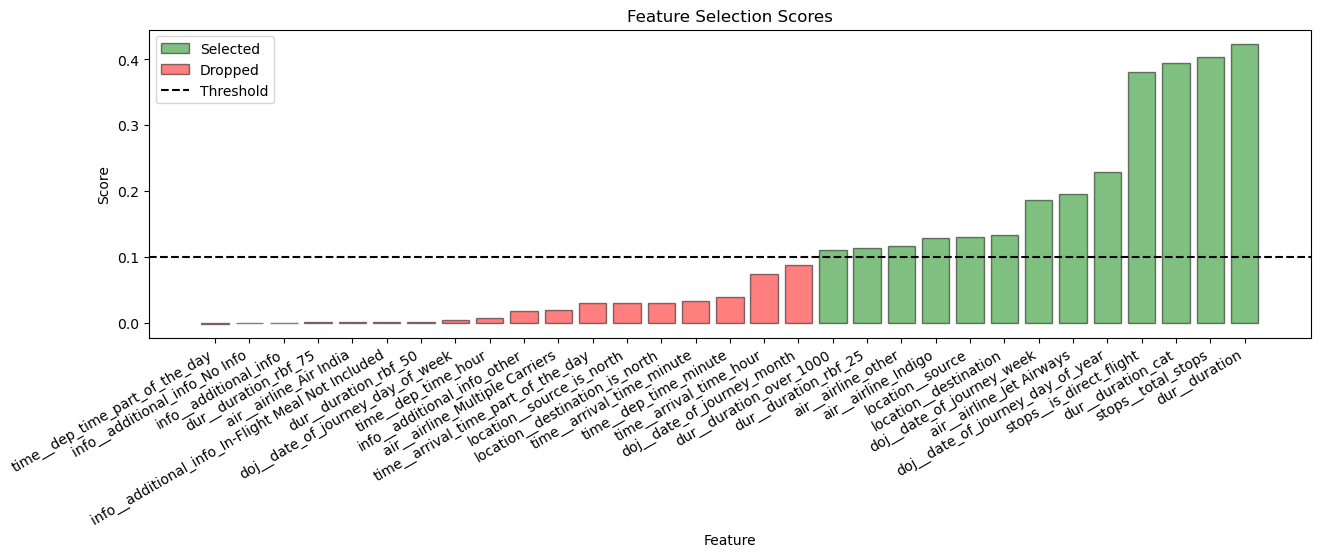

In [49]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

# 8. dumping the preprocessor

In [51]:
FILE_PATH = r"C:\Users\DELL\Desktop\Programming\ml-project2-flight-price-prediction-using-aws-sagemaker\models"
FILE_NAME = "preprocessor.pkl"

joblib.dump(preprocessor, os.path.join(FILE_PATH, FILE_NAME))

['C:\\Users\\DELL\\Desktop\\Programming\\ml-project2-flight-price-prediction-using-aws-sagemaker\\models\\preprocessor.pkl']

**Important note:** As preprocessor used some userdefined function like is_north, duration_category and is_over etc.
and also a user defined class RBFPercentileSimilarity
<br>
So we need to import these functions and class while using preprocessor